In [3]:
# import pakietów
import pandas as pd
import urllib
from IPython.display import HTML
from urllib.request import urlopen
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import re
from statistics import mean

In [4]:
#import danych
col_names = ['ID', 'gender', 'city', 'income', 'birth_date', 'application_date', 'requested_amount', 
             'requested_period', 'financial_obligations', 'employer_name', 'account_bank', 'mobile_verification_flag',
             'var_5', 'var_1', 'offer_amount', 'offer_period', 'interest_rate', 'fee', 'offer_monthly_obligation',
             'filled_form_flag', 'device', 'var_2', 'source', 'var_4', 'logged_in_flag', 'disbursed_flag']
dataset = pd.read_csv('C:/Users/Jacek/Desktop/projekt zaliczeniowy/dataset.csv', delimiter = ',', dtype='str', 
                      header = None, names = col_names, engine='python', index_col = False, skiprows = 1 )

HTML(dataset.head().to_html())

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Jacek/Desktop/projekt zaliczeniowy/dataset.csv'

In [3]:
months_dict = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06',
               'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

# TO DO - opis funckji i testy jednostkowe
def date_transform(date:str, twentieth_cent=False):
    day = date[:2]
    month = months_dict[date[3:6]]
    if twentieth_cent:
        return '19' + date[-2:] + "-" + month + "-" + day
    else:
        return '20' + date[-2:] + "-" + month + "-" + day

# formatowanie danych
dataset['income'] = dataset['income'].astype(float)
dataset['birth_date'] = dataset.apply(lambda x: date_transform(x['birth_date'], True), axis=1)
dataset['application_date'] = dataset.apply(lambda x: date_transform(x['application_date']), axis=1)
dataset['requested_amount'] = dataset['requested_amount'].astype(float)
dataset['financial_obligations'] = dataset['financial_obligations'].astype(float)

HTML(dataset.head().to_html())

,ID,gender,city,income,birth_date,application_date,requested_amount,requested_period,financial_obligations,employer_name,account_bank,mobile_verification_flag,var_5,var_1,offer_amount,offer_period,interest_rate,fee,offer_monthly_obligation,filled_form_flag,device,var_2,source,var_4,logged_in_flag,disbursed_flag
0,ID000002C20,Female,Delhi,20000.0,1978-05-23,2015-05-15,300000.0,5,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Web-browser,G,S122,1,0,0
1,ID002616Q10,Female,Madurai,11000.0,1989-07-10,2015-05-03,0.0,0,0.0,SAI BPO SERVICES LTD,ICICI Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Mobile,C,S133,1,0,0
2,ID000004E40,Male,Mumbai,35000.0,1985-10-07,2015-05-04,200000.0,2,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000,2,13.25,nan,6762.9,N,Web-browser,G,S122,3,0,0
3,ID000007H20,Male,Panchkula,22500.0,1981-10-10,2015-05-19,600000.0,4,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000,4,nan,nan,nan,N,Web-browser,B,S143,1,0,0
4,ID000008I30,Male,Saharsa,35000.0,1987-11-30,2015-05-09,1000000.0,5,0.0,BIHAR GOVERNMENT,State Bank of India,Y,10,HBXX,920000,5,nan,nan,nan,N,Web-browser,B,S143,3,0,0


In [4]:
# gps coordinates of cities from Internet
min_latitude = 7
max_latitude = 38
min_longitude = 67
max_longitude = 98

def get_coords_from_pattern(string, pattern):
    coords = string.split(" ")
    degs = float(coords[0].split(pattern[6])[0])
    mins = float(coords[1].split(pattern[16])[0])
    secs = float(coords[2].split(pattern[33])[0])
    return degs + mins/60.0 + secs/3600.0


def convert_list_to_coord(found, pattern):
    n, e = None, None
    found_n, found_e = [], []
    # wiki pattern
    if 'nsew' not in pattern:
        found_n = [float(item.split(" ")[0].split('°')[0]) for item in found]
        found_e = [float(item.split(" ")[1].split('°')[0]) for item in found]
    # google patterns
    else:
        found_n = [get_coords_from_pattern(item, pattern) for item in found if item[-1]=='n']
        found_e = [get_coords_from_pattern(item, pattern) for item in found if item[-1]=='e']
        found_n = [coord for coord in found_n if coord >= min_latitude and coord <= max_latitude]
        found_e = [coord for coord in found_e if coord >= min_longitude and coord <= max_longitude]
    if found_n:
        n = mean(found_n)
    if found_e:
        e = mean(found_e)               
    return [n, e]


# 1 - data directly from Wikipedia
def get_wikipedia_data(city):
    pattern = "[0-9]+.[0-9]+°n [0-9]+.[0-9]+°e"
    found = []
    try:
        with urlopen("https://en.wikipedia.org/wiki/" + city) as page:
            soup = BeautifulSoup(page.read(), "html.parser")
            response_list = soup.select(".geo-dec")            
            for item in response_list:
                found += re.findall(pattern, item.get_text().lower())
    except urllib.request.HTTPError:
        pass
    return convert_list_to_coord(found, pattern)


# 2 - data from google search results   
def get_google_search_data(city):
    pattern = "[0-9]+°[ ][0-9]+'[ ][0-9]+.[0-9]+''[ ][nsew]"
    found = []        
    driver.get('https://www.google.pl/search?q=' + city + '+latitude+and+longitude+in+decimal')
    found = re.findall(pattern, driver.page_source.lower())
    return convert_list_to_coord(found, pattern)


def get_latitude_to_data(city):
    pattern = "[0-9]+°[ ][0-9]+'[ ][0-9]+.[0-9]+\"[ ][nsew]"
    found = []        
    driver.get('https://www.google.pl/search?q=' + city + '+india+gps+coords')
    try:
        links = driver.find_elements_by_css_selector('.rc')
        links = [item for item in links if 'latitude.to' in item.text.lower()]
        if links:
            links[0].find_element_by_css_selector('h3').click()
            undone = True
            while undone:
                if 'google' not in driver.current_url:
                    try:
                        found = re.findall(pattern, driver.page_source.lower())
                    except NoSuchElementException:
                        pass                        
                    undone = False
    except NoSuchElementException:
        pass
    return convert_list_to_coord(found, pattern)

In [5]:
# cities = sorted(list(set(dataset['city'])))
# driver = webdriver.Chrome('chromedriver')

# coords = {}
# for item in cities:
#     coords[item] = get_wikipedia_data(item)
#     if coords[item][0] == None or coords[item][1] == None:
#         coords[item] = get_google_search_data(item)
#     if coords[item][0] == None or coords[item][1] == None:
#         coords[item] = get_latitude_to_data(item)   
# driver.close()

# cities_coords = pd.DataFrame.from_dict(coords, orient='index', columns = ['city', 'coords'])
# cities_coords.to_csv('C:/Users/Jacek/Desktop/projekt zaliczeniowy/gps_coords.csv')
cities_coords = pd.read_csv('C:/Users/Jacek/Desktop/projekt zaliczeniowy/gps_coords.csv', names = ['city', 'latitude', 'longitude'], skiprows = 1)
cities_coords = cities_coords[~pd.isnull(cities_coords['latitude'])]
dataset2 = pd.merge(dataset, cities_coords, on = 'city', how='left')

In [67]:
# income - replacing outliers with median
percentile_level = 99
import statistics as stat
import numpy as np

incomes = list(dataset2['income'])
incomes_count = len(incomes)
incomes_mean = stat.mean(incomes)
incomes_median = stat.median(incomes)
incomes_stddev = stat.stdev(incomes)
incomes_min = min(incomes)
incomes_max = max(incomes)
incomes_perc_1 = np.percentile(dataset2['income'], 1, axis=0)
incomes_perc_up = np.percentile(dataset2['income'], percentile_level, axis=0)

print("n \t" + str(incomes_count))
print("min \t" + str(incomes_min))
print("perc_1 \t" + str(incomes_perc_1))
print("median \t" + str(incomes_median))
print("mean \t" + str(incomes_mean))
print("stddev \t" + str(incomes_stddev))
print("perc_up\t" + str(incomes_perc_up))
print("max \t" + str(incomes_max) + "\n")
income_outliers = [income for income in incomes if income < incomes_perc_1 or income > incomes_perc_up]
print('number of outliers: ' + str(len(income_outliers)) + "\n")
incomes = [income if income >= incomes_perc_1 and income <= incomes_perc_up else incomes_median for income in incomes]
dataset2['income'] = dataset.apply(lambda x: x['income'] if incomes_perc_up >= x['income'] >= incomes_perc_1 else incomes_median, axis = 1)

incomes = list(dataset2['income'])
incomes_count = len(incomes)
incomes_mean = stat.mean(incomes)
incomes_median = stat.median(incomes)
incomes_stddev = stat.stdev(incomes)
incomes_min = min(incomes)
incomes_max = max(incomes)

print("n \t" + str(incomes_count))
print("min \t" + str(incomes_min))
print("perc_1 \t" + str(np.percentile(dataset2['income'], 1, axis=0)))
print("median \t" + str(incomes_median))
print("mean \t" + str(incomes_mean))
print("stddev \t" + str(incomes_stddev))
print("perc_up\t" + str(np.percentile(dataset2['income'], percentile_level, axis=0)))
print("max \t" + str(incomes_max) + "\n")

n 	87020
min 	2583.0
perc_1 	7500.0
median 	25000.0
mean 	32982.930016088256
stddev 	28592.258389480143
perc_up	170000.0
max 	250000.0



In [81]:
# age at the moment of application

def get_date_diff_in_years(date_start, date_end):
    out  = int(date_end[:4]) - int(date_start[:4])
    out += (int(date_end[5:7]) - int(date_start[5:7]))/12.0
    out += (int(date_end[8:]) - int(date_start[8:]))/30.5
    return round(out, 3)

dataset2['age'] = dataset2.apply(lambda x: get_date_diff_in_years(x['birth_date'], x['application_date']), axis=1)
HTML(dataset2.head().to_html())


,ID,gender,city,income,birth_date,application_date,requested_amount,requested_period,financial_obligations,employer_name,account_bank,mobile_verification_flag,var_5,var_1,offer_amount,offer_period,interest_rate,fee,offer_monthly_obligation,filled_form_flag,device,var_2,source,var_4,logged_in_flag,disbursed_flag,latitude,longitude,age
0,ID000002C20,Female,Delhi,20000.0,1978-05-23,2015-05-15,300000.0,5,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Web-browser,G,S122,1,0,0,28.610000,77.23000,36.738
1,ID002616Q10,Female,Madurai,11000.0,1989-07-10,2015-05-03,0.0,0,0.0,SAI BPO SERVICES LTD,ICICI Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Mobile,C,S133,1,0,0,9.912292,78.10986,25.604
2,ID000004E40,Male,Mumbai,35000.0,1985-10-07,2015-05-04,200000.0,2,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000,2,13.25,nan,6762.9,N,Web-browser,G,S122,3,0,0,18.975000,72.82583,29.485
3,ID000007H20,Male,Panchkula,22500.0,1981-10-10,2015-05-19,600000.0,4,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000,4,nan,nan,nan,N,Web-browser,B,S143,1,0,0,30.740000,76.80000,33.878
4,ID000008I30,Male,Saharsa,35000.0,1987-11-30,2015-05-09,1000000.0,5,0.0,BIHAR GOVERNMENT,State Bank of India,Y,10,HBXX,920000,5,nan,nan,nan,N,Web-browser,B,S143,3,0,0,25.880000,86.60000,26.811


In [82]:
dataset2.to_csv('C:/Users/Jacek/Desktop/projekt zaliczeniowy/datamata.csv', sep = ';')

In [96]:
dataset2['requested_period'] = dataset2.apply(lambda x: x['requested_period'] if x['requested_period']is not 'nan' else None, axis = 1)
dataset2['requested_period'] = dataset2['requested_period'].astype(int)
requested_amount_median = stat.median(dataset2['requested_amount'])
requested_period_median = stat.median(dataset2['requested_period'])
financial_obligations_median = stat.median(ataset2['financial_obligations'])

dataset2['requested_amount'] = dataset2.apply(lambda x: x['requested_amount'] if ~x['requested_amount'].isnull() else requested_amount_median, axis = 1)
dataset2['requested_period'] = dataset2.apply(lambda x: x['requested_period'] if ~x['requested_period'].isnull() else requested_period_median, axis = 1)
dataset2['financial_obligations'] = dataset2.apply(lambda x: x['financial_obligations'] if ~x['financial_obligations'].isnull() else financial_obligations_median, axis = 1)


ValueError: invalid literal for int() with base 10: 'nan'

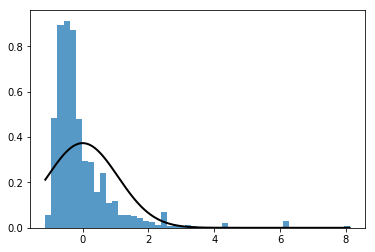

p-values for all 87020 data points: ----------------
Omnibus         0.0
Shapiro-Wilk    0.0
Lilliefors      0.0
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


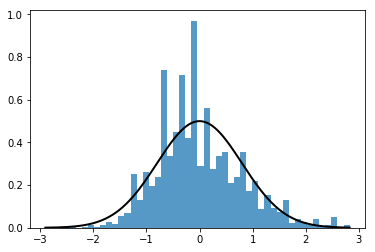

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-values for all 87020 data points: ----------------
Omnibus         0.0
Shapiro-Wilk    0.0
Lilliefors      0.0
dtype: float64


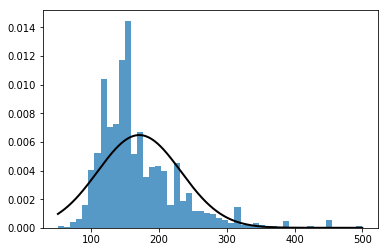

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-values for all 87020 data points: ----------------
Omnibus         0.0
Shapiro-Wilk    0.0
Lilliefors      0.0
dtype: float64


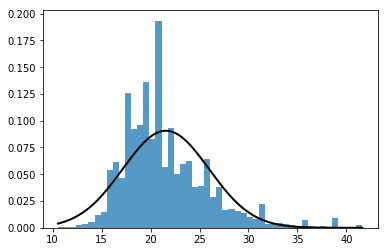

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-values for all 87020 data points: ----------------
Omnibus         0.0
Shapiro-Wilk    0.0
Lilliefors      0.0
dtype: float64


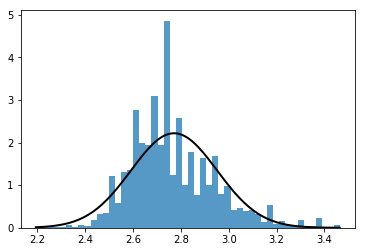

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-values for all 87020 data points: ----------------
Omnibus         0.0
Shapiro-Wilk    0.0
Lilliefors      0.0
dtype: float64


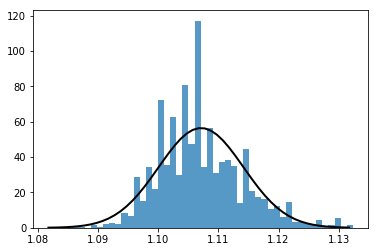

p-values for all 87020 data points: ----------------
Omnibus         0.0
Shapiro-Wilk    0.0
Lilliefors      0.0
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [32]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.diagnostic import lilliefors
import math
power1 = 0.5
power2 = 0.3
power3 = 0.1
power4 = 0.01
num_bins = 50

incomes_norm = [income / incomes_median for income in incomes]
incomes_log  = [math.log(income) for income in incomes]
incomes_pow1 = [math.pow(income, power1) for income in incomes]
incomes_pow2 = [math.pow(income, power2) for income in incomes]
incomes_pow3 = [math.pow(income, power3) for income in incomes]
incomes_pow4 = [math.pow(income, power4) for income in incomes]

# n, bins, patches = plt.hist(incomes_sqrt, bins=40, facecolor='g')
# plt.show()

plt.figure()
mu_1, sigma_1 = stats.norm.fit(incomes_norm)
incomes_norm = [ (income - mu_1)/math.pow(sigma_1, 0.5) for income in incomes_norm]
mu_1, sigma_1 = stats.norm.fit(incomes_norm)
t1 = np.arange(min(incomes_norm), max(incomes_norm), 0.001)
plt.hist(incomes_norm, bins = num_bins, density=True, histtype='stepfilled', alpha=0.75, label='normalized')
plt.plot(t1, stats.norm.pdf(t1, mu_1, sigma_1), 'k-', lw=2, label='a=-1, b=1')
plt.show()

pVals = pd.Series()
_, pVals['Omnibus']    = stats.normaltest(incomes_norm)
_, pVals['Shapiro-Wilk']    = stats.shapiro(incomes_norm)
_, pVals['Lilliefors']    = lilliefors(incomes_norm)
print('p-values for all {0} data points: ----------------'.format(len(incomes_norm)))
print(pVals)


plt.figure()
mu_2, sigma_2 = stats.norm.fit(incomes_log)
incomes_log = [ (income - mu_2)/math.pow(sigma_2, 0.5) for income in incomes_log]
plt.hist(incomes_log, bins = num_bins, density=True, histtype='stepfilled', alpha=0.75, label='logarithm')
t2 = np.arange(min(incomes_log), max(incomes_log), 0.0001)
mu_2, sigma_2 = stats.norm.fit(incomes_log)
plt.plot(t2, stats.norm.pdf(t2, mu_2, sigma_2), 'k-', lw=2, label='a=-1, b=1')
plt.show()

pVals = pd.Series()
_, pVals['Omnibus']    = stats.normaltest(incomes_log)
_, pVals['Shapiro-Wilk']    = stats.shapiro(incomes_log)
_, pVals['Lilliefors']    = lilliefors(incomes_log)
print('p-values for all {0} data points: ----------------'.format(len(incomes_log)))
print(pVals)

plt.figure()
plt.hist(incomes_pow1, bins = num_bins, density=True, histtype='stepfilled', alpha=0.75, label='power ' + str(power1))
t3 = np.arange(min(incomes_pow1), max(incomes_pow1), 0.01)
mu_3, sigma_3 = stats.norm.fit(incomes_pow1)
plt.plot(t3, stats.norm.pdf(t3, mu_3, sigma_3), 'k-', lw=2, label='a=-1, b=1')
plt.show()

pVals = pd.Series()
_, pVals['Omnibus']    = stats.normaltest(incomes_pow1)
_, pVals['Shapiro-Wilk']    = stats.shapiro(incomes_pow1)
_, pVals['Lilliefors']    = lilliefors(incomes_pow1)
print('p-values for all {0} data points: ----------------'.format(len(incomes_pow1)))
print(pVals)


plt.figure()
plt.hist(incomes_pow2, bins = num_bins, density=True, histtype='stepfilled', alpha=0.75, label='power 0.3')
t4 = np.arange(min(incomes_pow2), max(incomes_pow2), 0.01)
mu_4, sigma_4 = stats.norm.fit(incomes_pow2)
plt.plot(t4, stats.norm.pdf(t4, mu_4, sigma_4), 'k-', lw=2, label='a=-1, b=1')
plt.show()

pVals = pd.Series()
_, pVals['Omnibus']    = stats.normaltest(incomes_pow2)
_, pVals['Shapiro-Wilk']    = stats.shapiro(incomes_pow2)
_, pVals['Lilliefors']    = lilliefors(incomes_pow2)
print('p-values for all {0} data points: ----------------'.format(len(incomes_pow2)))
print(pVals)


plt.figure()
plt.hist(incomes_pow3, bins = num_bins, density=True, histtype='stepfilled', alpha=0.75, label='power 0.1')
t5 = np.arange(min(incomes_pow3), max(incomes_pow3), 0.01)
mu_5, sigma_5 = stats.norm.fit(incomes_pow3)
plt.plot(t5, stats.norm.pdf(t5, mu_5, sigma_5), 'k-', lw=2, label='a=-1, b=1')
plt.show()

pVals = pd.Series()
_, pVals['Omnibus']    = stats.normaltest(incomes_pow3)
_, pVals['Shapiro-Wilk']    = stats.shapiro(incomes_pow3)
_, pVals['Lilliefors']    = lilliefors(incomes_pow3)
print('p-values for all {0} data points: ----------------'.format(len(incomes_pow3)))
print(pVals)


plt.figure()
plt.hist(incomes_pow4, bins = num_bins, density=True, histtype='stepfilled', alpha=0.75, label='power 0.01')
t6 = np.arange(min(incomes_pow4), max(incomes_pow4), 0.001)
mu_6, sigma_6 = stats.norm.fit(incomes_pow4)
plt.plot(t6, stats.norm.pdf(t6, mu_6, sigma_6), 'k-', lw=2, label='a=-1, b=1')
plt.show()

pVals = pd.Series()
_, pVals['Omnibus']    = stats.normaltest(incomes_pow4)
_, pVals['Shapiro-Wilk']    = stats.shapiro(incomes_pow4)
_, pVals['Lilliefors']    = lilliefors(incomes_pow4)
print('p-values for all {0} data points: ----------------'.format(len(incomes_pow4)))
print(pVals)


# import matplotlib.pyplot as plt
# plt.figure(1)                # the first figure
# plt.subplot(211)             # the first subplot in the first figure
# plt.plot([1, 2, 3])
# plt.subplot(212)             # the second subplot in the first figure
# plt.plot([4, 5, 6])


# plt.figure(2)                # a second figure
# plt.plot([4, 5, 6])          # creates a subplot(111) by default

# plt.figure(1)                # figure 1 current; subplot(212) still current
# plt.subplot(211)             # make subplot(211) in figure1 current
# plt.title('Easy as 1, 2, 3') # subplot 211 title




# fig, ax = plt.subplots(1, 3, squeeze=True)
# fig1 = ax[0].hist(incomes_norm, bins = num_bins, normed=True, histtype='stepfilled', alpha=0.75, label='normalized')
# fig1[0]=12
# ax[1].hist(incomes_log, bins = num_bins, normed=True, histtype='stepfilled', alpha=0.75, label='logarithm')
# ax[2].hist(incomes_pow1, bins = num_bins, normed=True, histtype='stepfilled', alpha=0.75, label='power ' + str(power1))
# plt.show()
# fig, ax = plt.subplots(1, 3, sharey=True)
# ax[0].hist(incomes_pow2, bins = num_bins, normed=True, histtype='stepfilled', alpha=0.75, label='power 0.3')
# ax[1].hist(incomes_pow3, bins = num_bins, normed=True, histtype='stepfilled', alpha=0.75, label='power 0.1')
incomes# ax[2].hist(incomes_pow4, bins = num_bins, normed=True, histtype='stepfilled', alpha=0.75, label='power 0.01')

In [64]:
N = 100
params_list = range(0, N)

for pow in params_list:
#     print("param = " + str(pow) + "\n")
    pow = pow / N
    incomes_test = incomes
    incomes_test = stats.boxcox(incomes_test, lmbda = pow)
    mu, sigma = stats.norm.fit(incomes_test)
#     print("mu = " + str(mu) + " sigma = " + str(sigma))
#     print("\nNormalizacja\n")
    incomes_test = [(income - mu)/sigma for income in incomes_test]
    mu, sigma = stats.norm.fit(incomes_test)
#     print("mu = " + str(mu) + " sigma = " + str(sigma))

#     plt.figure()
#     t = np.arange(min(incomes_test), max(incomes_test), 0.001)
#     plt.hist(incomes_test, bins = num_bins, density=True, histtype='stepfilled', alpha=0.75, label='normalized')
#     plt.plot(t, stats.norm.pdf(t, mu, sigma), 'k-', lw=1,)
#     plt.show()

    pVals = pd.Series()
    _, pVals['Omnibus'] = stats.normaltest(incomes_test)
    _, pVals['Shapiro-Wilk'] = stats.shapiro(incomes_test)
    _, pVals['Lilliefors'] = lilliefors(incomes_test)
#     print('p-values for all {0} data points: ----------------'.format(len(incomes_test)))
#     print(pVals)
    print(str(pow) + "\t" + str(pVals['Omnibus']) + "\t" + str(pVals['Shapiro-Wilk']) + "\t" + str(pVals['Lilliefors']))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.0	0.0	0.0	0.0
0.01	0.0	0.0	0.0
0.02	0.0	0.0	0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.03	0.0	0.0	0.0
0.04	0.0	0.0	0.0
0.05	0.0	0.0	0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.06	0.0	0.0	0.0
0.07	0.0	0.0	0.0
0.08	0.0	0.0	0.0
0.09	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.1	0.0	0.0	0.0
0.11	0.0	0.0	0.0
0.12	0.0	0.0	0.0
0.13	0.0	0.0	0.0
0.14	0.0	0.0	0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.15	0.0	0.0	0.0
0.16	0.0	0.0	0.0
0.17	0.0	0.0	0.0
0.18	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.19	0.0	0.0	0.0
0.2	0.0	0.0	0.0
0.21	0.0	0.0	0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.22	0.0	0.0	0.0
0.23	0.0	0.0	0.0
0.24	0.0	0.0	0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.25	0.0	0.0	0.0
0.26	0.0	0.0	0.0
0.27	0.0	0.0	0.0
0.28	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.29	0.0	0.0	0.0
0.3	0.0	0.0	0.0
0.31	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.32	0.0	0.0	0.0
0.33	0.0	0.0	0.0
0.34	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.35	0.0	0.0	0.0
0.36	0.0	0.0	0.0
0.37	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.38	0.0	0.0	0.0
0.39	0.0	0.0	0.0
0.4	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.41	0.0	0.0	0.0
0.42	0.0	0.0	0.0
0.43	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.44	0.0	0.0	0.0
0.45	0.0	0.0	0.0
0.46	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.47	0.0	0.0	0.0
0.48	0.0	0.0	0.0
0.49	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.5	0.0	0.0	0.0
0.51	0.0	0.0	0.0
0.52	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.53	0.0	0.0	0.0
0.54	0.0	0.0	0.0
0.55	0.0	0.0	0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.56	0.0	0.0	0.0
0.57	0.0	0.0	0.0
0.58	0.0	0.0	0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.59	0.0	0.0	0.0
0.6	0.0	0.0	0.0
0.61	0.0	0.0	0.0
0.62	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.63	0.0	0.0	0.0
0.64	0.0	0.0	0.0
0.65	0.0	0.0	0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.66	0.0	0.0	0.0
0.67	0.0	0.0	0.0
0.68	0.0	0.0	0.0
0.69	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.7	0.0	0.0	0.0
0.71	0.0	0.0	0.0
0.72	0.0	0.0	0.0
0.73	0.0	0.0	0.0
0.74	0.0	0.0	0.0
0.75	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.76	0.0	0.0	0.0
0.77	0.0	0.0	0.0
0.78	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.79	0.0	0.0	0.0
0.8	0.0	0.0	0.0
0.81	0.0	0.0	0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.82	0.0	0.0	0.0
0.83	0.0	0.0	0.0
0.84	0.0	0.0	0.0
0.85	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.86	0.0	0.0	0.0
0.87	0.0	0.0	0.0
0.88	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.89	0.0	0.0	0.0
0.9	0.0	0.0	0.0
0.91	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.92	0.0	0.0	0.0
0.93	0.0	0.0	0.0
0.94	0.0	0.0	0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.95	0.0	0.0	0.0
0.96	0.0	0.0	0.0
0.97	0.0	0.0	0.0
0.98	0.0	0.0	0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



0.99	0.0	0.0	0.0


In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans, vq
import seaborn as sns


In [ ]:
cities_cluster = dataset2[['city', 'latitude', 'longitude']]
cities_cluster["scaled_latitude"] = whiten(cities_cluster["latitude"])
cities_cluster["scaled_longitude"] = whiten(cities_cluster["longitude"])

dist = []
num_clusters = range(1, 10)
for i in num_clusters:
    cluster_centers, distortion = kmeans(cities_cluster[["scaled_latitude","scaled_longitude"]],i)
    dist.append(distortion)

elbow_plot = pd.DataFrame({"num_clusters": num_clusters, "distortion": dist})
sns.lineplot(x="num_clusters", y="distortion", data=elbow_plot)


In [ ]:
cities_cluster = cities_cluster[['scaled_longitude', 'scaled_latitude']]
centroids, _ = kmeans(cities_cluster, 8)

cities_cluster['cluster_labels'], _ = vq(cities_cluster, centroids)

sns.scatterplot(x="scaled_longitude", y="scaled_latitude", data=cities_cluster, hue="cluster_labels")
plt.show()